# Clustering the abstracts
I'd like to be able to make a un-supervised clustering of the abstracts to answer some questions:  
1) Do the abstracts cluster based on section or super-section?  
2) Are there clusters that are not represented by the sections  
3) Are there individuals who maybe submitted their abstract to the wrong section?  
  
Going to follow a tutorial that I found first: http://brandonrose.org/clustering

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import os
import codecs
import mpld3

import nltk
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 

## Extract the text of the abstracts at the conference
I think a better solution is to copy everything into a text file, and then follow a simple chain of logic to parse it.

- Every ID number comes IN ORDER in the file.
- Every ID number comes after a new line and is followed by a space.
- So if we scan line by line, and incriment the ID we are looking for, then it is really unlikely that we will run into any conflicts (i.e. next ID is 100 and 100 is used in the text of 99, causing it to be split.)  
- Finally, we want to ommit the author line for each abstract. This will work since the author line and the text line are seperate

In [2]:
with open("dros_2019_data/Dros19_Abstracts_Full_v2_hard-Copy.txt", 'r') as f:
    
    abstracts = {}
    idfind = 2
    record = ''
    author = True
    author_line = ''
    
    for line in f:
        line = line.rstrip()
        if (str(idfind + 1) + ' ') in line:
            abstracts[str(idfind)] = {
                'text' : '',
                'author' : '',
                'type' : '',
                'section' : '',
            }
            abstracts[str(idfind)]['text'] = record
            abstracts[str(idfind)]['author'] = author_line
            record = ''
            author_line = ''
            idfind += 1
            author = True
        if author:
            author_line = line.split('.')[0]
#             print(author_line)
            author = False
        else:
            record += line
            
print(len(abstracts), 'abtracts')

844 abtracts


## Web Scraping the Dros 2019 abstract assignment data
The data for abstracts at this conference comes in two parts - first, the PDF that actually has all the abstracts in them. However, that PDF doesn't have the abstract assignment (poster or talk). For the assignment, we need the conference web page: http://conferences.genetics-gsa.org/drosophila/2019/assignments  
  
The assignments are in a large table, that is thankfully continuous over the whole page. The table has the presenter's name, partial abstract title, session assignment, program #, session date, and presentation time. We need hte session assignment and the program number. The number will allow us to connect it to the correct abstract in the program.  
  
I've saved the web page in this folder in case it changes or gets removed. At this point it's not going to change anyway.

In [3]:
# we tell BeautifulSoup and tell it which parser to use
soup = BeautifulSoup(open("dros_2019_data/abstract_lookup.html"), "html.parser")

# make a pandas data frame from the table on the website
ab_table = soup.find(id="authassign-All")
abstracts_df = pd.read_html(str(ab_table))[0]

session_list = abstracts_df['Session Assignment'].values

# group the assignments together
for idx, num in enumerate(abstracts_df['Program #'].values):
    if "P" not in num:
        
        if num in abstracts:
        
            if "Poster" in session_list[idx]:
                abstracts[str(num)]['type'] = 'poster'
                abstracts[str(num)]['section'] = session_list[idx].split('Poster')[1].lower()


            if "Plenary" in session_list[idx]:
                abstracts[str(num)]['type'] = 'talk'
                abstracts[str(num)]['section'] = session_list[idx][7:].lower()


            if "Platform" in session_list[idx]:
                abstracts[str(num)]['type'] = 'talk'
                abstracts[str(num)]['section'] = session_list[idx].split('Platform')[1].lower()

# pop out the ones that we don't have complete info for 
# (only found 2, 267 and 282), probably due to lack of info on the
# web page

remove = [ab for ab in abstracts if not abstracts[ab]['type'] or not abstracts[ab]['section']]
for k in remove: del abstracts[k]

    

In [4]:
section_groups = {
    'cell biology: cytoskeleton, organelles and trafficking' : 'cell bio',
    'cell biology: cytoskeleton, organelles, trafficking' : 'cell bio',
    'cell death and cell stress' : 'cell bio',
    'cell division and cell growth' : 'cell bio',
    'cell division and growth control' : 'cell bio',
    'cell stress and cell death' : 'cell bio',
    'chromatin, epigenetics and genomics' : 'gene expression',
    'chromatin, epigenetics and genomics ii' : 'gene expression',
    'education ' : 'education',
    'educational initiatives' : 'education',
    'evolution' : 'evolution',
    'evolution i' : 'evolution',
    'evolution ii' : 'evolution',
    'immunity and the microbiome' : 'models of human disease',
    'models of human disease' : 'models of human disease',
    'models of human disease i' : 'models of human disease',
    'models of human disease ii' : 'models of human disease',
    'neural circuits and behavior' : 'neurobiology',
    'neural circuits and behavior i' : 'neurobiology',
    'neural development and physiology' : 'neurobiology',
    'neural development and physiology ii/neural circuits and behavior ii'  : 'neurobiology',
    'patterning, morphogenesis and organogenesis' : 'developmental biology',
    'patterning, morphogenesis and organogenesis i' : 'developmental biology',
    'patterning, morphogenesis and organogenesis ii' : 'developmental biology',
    'physiology, metabolism and aging' : 'developmental biology',
    'physiology, metabolism and aging i' : 'developmental biology',
    'physiology, metabolism and aging ii' : 'developmental biology',
    'plenary ii' : 'plenary',
    'plenary session i' : 'plenary',
    'regulation of gene expression' : 'gene expression',
    'regulation of gene expression i' : 'gene expression',
    'regulation of gene expression ii/ chromatin, epigenetics and genomics i' : 'gene expression',
    'reproduction and gametogenesis'  : 'developmental biology',
    'signal transduction'  : 'developmental biology',
    'stem cells, regeneration and tissue injury'  : 'developmental biology',
    'techniques & technology' : 'education'    
}

# and add the groups
for ab in abstracts:
    abstracts[ab]['group'] = section_groups[abstracts[ab]['section']]

## Clustering the abstracts
I'd like to be able to make a un-supervised clustering of the abstracts to answer some questions:  
1) Do the abstracts cluster based on section or super-section?  
2) Are there clusters that are not represented by the sections  
3) Are there individuals who maybe submitted their abstract to the wrong section?  
  
Going to follow a tutorial that I found first: http://brandonrose.org/clustering  
### Prep
We need several lists for this analysis.  
1) A list of the abstract numbers  
2) A list of the abstracts  
3) A list of the categories  / super categories

In [5]:
nums = []
texts = []
groups = []
authors = []
types = []
for ab in abstracts:
    nums.append(ab)
    texts.append(abstracts[ab]['text'])
    groups.append(abstracts[ab]['group'])
    authors.append(abstracts[ab]['author'])
    types.append(abstracts[ab]['type'])


### Stop words and Tokenizing
First, we need to remove the "stopwords", common english words that we don't want our analysis to focus on. Second, we need tokenize, which means to create a dataframe of the roots.

In [6]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [7]:
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'texts', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

From the web page:  
"Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up."

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 219626 items in vocab_frame


From the web page again:  
### Tf-idf and document similarity
Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

- max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)  
- min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
- ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams

In [11]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 6.56 s, sys: 74.4 ms, total: 6.64 s
Wall time: 6.67 s
(842, 68)


In [12]:
terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

In [35]:
num_clusters = 8

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 3.35 s, sys: 15.7 ms, total: 3.37 s
Wall time: 3.39 s


In [14]:
# from sklearn.externals import joblib

# #uncomment the below to save your model 
# #since I've already run my model I am loading from the pickle

# #joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

In [37]:
ab_sort = { 
    'author': authors, 
    'type': types, 
    'text': texts, 
    'cluster': clusters, 
    'group': groups 
}

frame = pd.DataFrame(ab_sort, index = [clusters] , columns = ['author', 'type', 'cluster', 'group'])
frame.head(10)

,author,type,cluster,group
1,2 Assembly and disassembly of germ plasm local...,talk,1,plenary
3,3 The I of the fly,talk,3,plenary
3,4 The gut microbiome: the driving and driven p...,talk,3,plenary
4,5 Interrogating centromere specification mecha...,talk,4,plenary
3,6 Tissue growth and metabolic sensing: from fl...,talk,3,plenary
2,7 Precision and plasticity in animal transcrip...,talk,2,plenary
3,8 Putting a STINGer on Drosophila: Evolutionar...,talk,3,models of human disease
3,9 Tradeoffs between immune defense and resista...,talk,3,models of human disease
4,10 Role of Circular RNAs in Innate Immunity an...,talk,4,models of human disease
4,11 Diet-induced microbiota adaptation is contr...,talk,4,models of human disease


In [38]:
#number of films per cluster (clusters from 0 to 4)
frame['cluster'].value_counts()

3    185
4    183
0    181
2    157
1    136
Name: cluster, dtype: int64

In [39]:
#groupby cluster for aggregation purposes
grouped = frame['type'].groupby(frame['cluster'])


In [40]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i)
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
#         print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d titles:" % i, end='')
#     for title in frame.ix[i]['author'].values.tolist():
#         print(' %s,' % title, end='')
#     print() #add whitespace
#     print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words:
protein
mutant
function
interactions
role
cells


Cluster 1 words:
cells
tissue
during
mechanisms
signaling
regulates


Cluster 2 words:
genes
expression
using
function
identified
genetically


Cluster 3 words:
fly
genetically
melanogaster
using
model


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


effects


Cluster 4 words:
activation
signaling
regulates
transcripts
expression
cells






### Multidimensional Scaling

In [19]:
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

From site:  
### Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [20]:
#set up colors per clusters using a dict
cluster_colors = {0: '#8dd3c7', 
                  1: '#a65628', 
                  2: '#bebada', 
                  3: '#fb8072', 
                  4: '#80b1d3',
                  5: '#fdb462',
                  6: '#b3de69',
                  7: '#fccde5',
                 }

#set up cluster names using a dict
cluster_names = {0: 'fly, effects, model', 
                 1: 'genetically, melanogaster, using', 
                 2: 'protein, function, regulates', 
                 3: 'cells, tissue, during', 
                 4: 'mutant, mutations, phenotypic',
                 5: 'genes, expression, fucntion',
                 6: 'transcripts, activation, expression',
                 7: 'signaling, regulates, cells',
                }

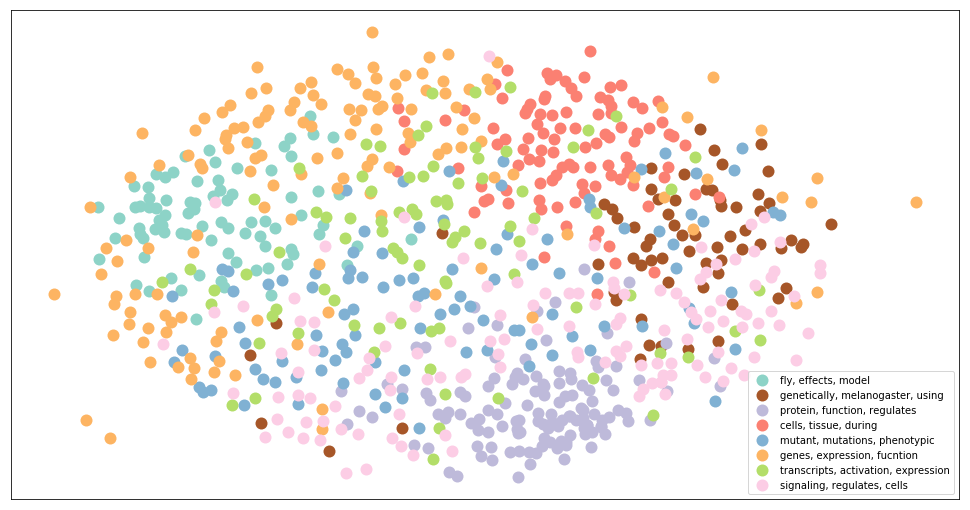

In [21]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=groups)) 
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

#group by cluster
groupss = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groupss:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


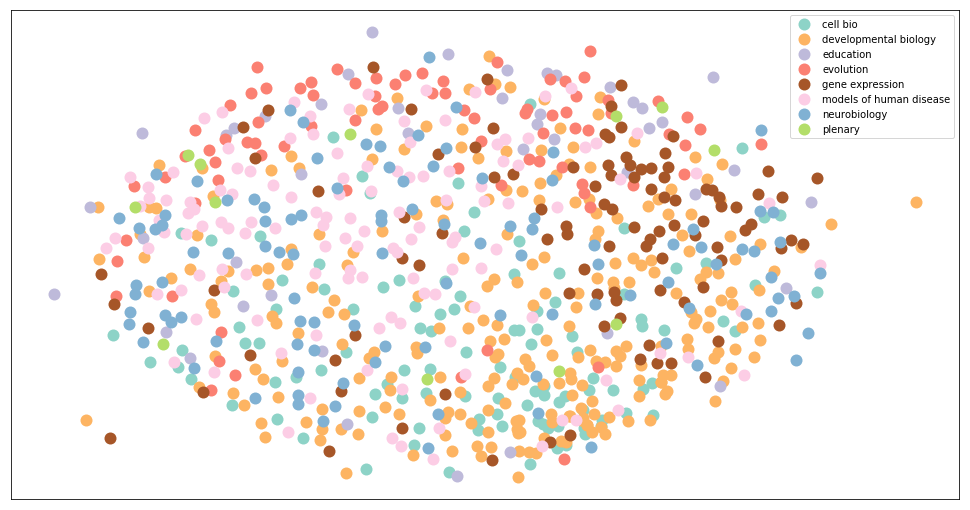

In [22]:
#set up colors per clusters using a dict
group_colors = {'cell bio': '#8dd3c7', 
                'gene expression': '#a65628', 
                'education': '#bebada', 
                'evolution': '#fb8072', 
                'neurobiology': '#80b1d3',
                'developmental biology': '#fdb462',
                'plenary': '#b3de69',
                'models of human disease': '#fccde5',
                }



#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=groups)) 
df = pd.DataFrame(dict(x=xs, y=ys, label=groups)) 

#group by cluster
groupss = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groupss:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=name, color=group_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

Well this is pretty! But I'm not sure it it more than that right now. Some general triends are there - most of the evolution abstracts are at the top, most of the devo abstracts are at the bottom, the gene expression ones to the right. However, many are scattered all around - human disease, neruobiology especially. As a quick note, we generally expect the plenary abstracts to be scattered, since they are not on a unified topic.

## PCA
I'm going to try using PCA to visualize this instead. I'm going to start with the "dist' object that we created earlier - this is the document term matrix computed to it's inverse weights for frequent word usage.

If I understand this correctly, this means that there are 66 parameters for all of our 842 abtracts. As a brief reminder, here are the different list that we have access too.  
`
nums = []
texts = []
groups = []
authors = []
types = []
for ab in abstracts:
    nums.append(ab)
    texts.append(abstracts[ab]['text'])
    groups.append(abstracts[ab]['group'])
    authors.append(abstracts[ab]['author'])
    types.append(abstracts[ab]['type'])
`

In [43]:
def pca_cloud(texts, max_df, min_df, clusters, groups):

    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, max_features=200000,
                                     min_df=min_df, stop_words='english',
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

    terms = tfidf_vectorizer.get_feature_names()
    dist = 1 - cosine_similarity(tfidf_matrix)

    
    pca_model = PCA()
    pos = pca_model.fit_transform(dist)
    xs, ys = pos[:, 0], pos[:, 1]
    var_ratio = pca_model.explained_variance_ratio_
    print("Var ratios", var_ratio[:5])
    
    #set up colors per clusters using a dict
    cluster_colors = {0: '#8dd3c7', 
                      1: '#a65628', 
                      2: '#bebada', 
                      3: '#fb8072', 
                      4: '#80b1d3',
                      5: '#fdb462',
                      6: '#b3de69',
                      7: '#fccde5',
                     }

    #set up cluster names using a dict
    cluster_names = {0: 'fly, effects, model', 
                     1: 'genetically, melanogaster, using', 
                     2: 'protein, function, regulates', 
                     3: 'cells, tissue, during', 
                     4: 'mutant, mutations, phenotypic',
                     5: 'genes, expression, fucntion',
                     6: 'transcripts, activation, expression',
                     7: 'signaling, regulates, cells',
                    }


    #set up colors per clusters using a dict
    group_colors = {'cell bio': '#8dd3c7', 
                    'gene expression': '#a65628', 
                    'education': '#bebada', 
                    'evolution': '#fb8072', 
                    'neurobiology': '#80b1d3',
                    'developmental biology': '#fdb462',
                    'plenary': '#b3de69',
                    'models of human disease': '#fccde5',
                    }

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    # df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=groups)) 
    df1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
    df2 = pd.DataFrame(dict(x=xs, y=ys, label=groups)) 

    #group by cluster
    groups1 = df1.groupby('label')
    groups2 = df2.groupby('label')

    # set up plot
    fig, ax = plt.subplots(2, figsize=(14, 14)) # set size
    ax[0].margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax[1].margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups1:
        ax[0].plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], color=cluster_colors[name], 
                mec='none')
        ax[0].set_aspect('auto')
        ax[0].tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax[0].tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False)

    ax[0].legend(numpoints=1)  #show legend with only 1 point


    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups2:
        ax[1].plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=name, color=group_colors[name], 
                mec='none')
        ax[1].set_aspect('auto')
        ax[1].tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax[1].tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False)

    ax[1].legend(numpoints=1)  #show legend with only 1 point    
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def mds_cloud(texts, max_df, min_df, clusters, groups):

    tfidf_vectorizer = TfidfVectorizer(max_df=max_df, max_features=200000,
                                     min_df=min_df, stop_words='english',
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

    terms = tfidf_vectorizer.get_feature_names()
    dist = 1 - cosine_similarity(tfidf_matrix)

    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    #set up colors per clusters using a dict
    cluster_colors = {0: '#8dd3c7', 
                      1: '#a65628', 
                      2: '#bebada', 
                      3: '#fb8072', 
                      4: '#80b1d3',
                      5: '#fdb462',
                      6: '#b3de69',
                      7: '#fccde5',
                     }

    #set up cluster names using a dict
    cluster_names = {0: 'fly, effects, model', 
                     1: 'genetically, melanogaster, using', 
                     2: 'protein, function, regulates', 
                     3: 'cells, tissue, during', 
                     4: 'mutant, mutations, phenotypic',
                     5: 'genes, expression, fucntion',
                     6: 'transcripts, activation, expression',
                     7: 'signaling, regulates, cells',
                    }


    #set up colors per clusters using a dict
    group_colors = {'cell bio': '#8dd3c7', 
                    'gene expression': '#a65628', 
                    'education': '#bebada', 
                    'evolution': '#fb8072', 
                    'neurobiology': '#80b1d3',
                    'developmental biology': '#fdb462',
                    'plenary': '#b3de69',
                    'models of human disease': '#fccde5',
                    }

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    # df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=groups)) 
    df1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
    df2 = pd.DataFrame(dict(x=xs, y=ys, label=groups)) 

    #group by cluster
    groups1 = df1.groupby('label')
    groups2 = df2.groupby('label')

    # set up plot
    fig, ax = plt.subplots(2, figsize=(14, 14)) # set size
    ax[0].margins(0.05) # Optional, just adds 5% padding to the autoscaling
    ax[1].margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups1:
        ax[0].plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=cluster_names[name], color=cluster_colors[name], 
                mec='none')
        ax[0].set_aspect('auto')
        ax[0].tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax[0].tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False)

    ax[0].legend(numpoints=1)  #show legend with only 1 point


    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups2:
        ax[1].plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=name, color=group_colors[name], 
                mec='none')
        ax[1].set_aspect('auto')
        ax[1].tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax[1].tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelleft=False)

    ax[1].legend(numpoints=1)  #show legend with only 1 point    
    
    plt.xlabel('Multidimensional vector 1')
    plt.ylabel('Multidimensional vector 2')
    plt.show()


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Var ratios [0.26570661 0.1438531  0.08441222 0.07124658 0.04880443]


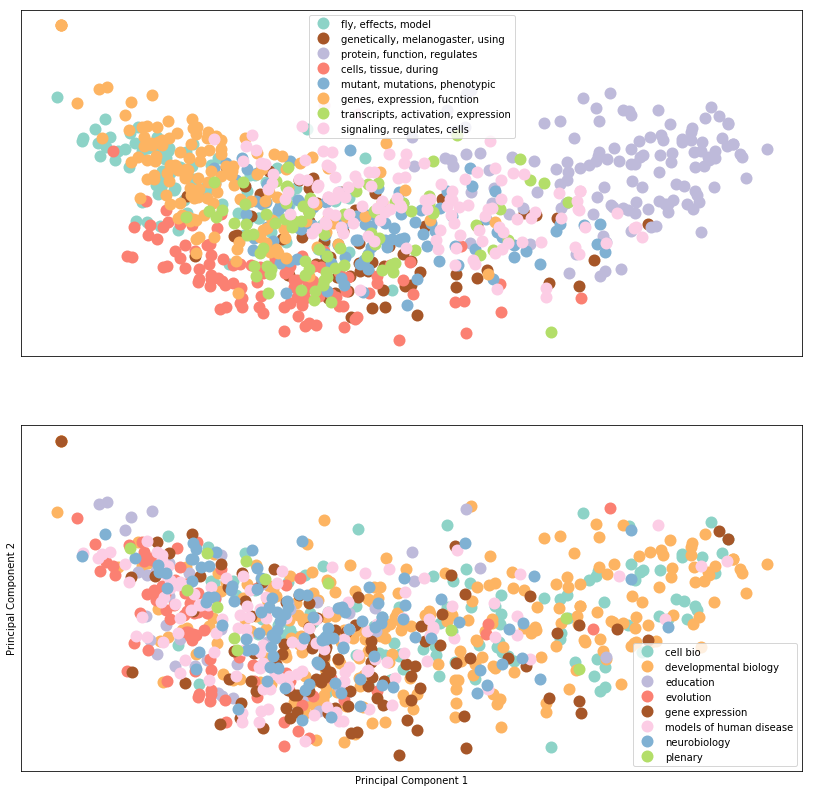

In [29]:
pca_cloud(texts, 0.8, 0.2, clusters, groups)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Var ratios [0.31255428 0.18755934 0.11893384 0.10472722 0.06460452]


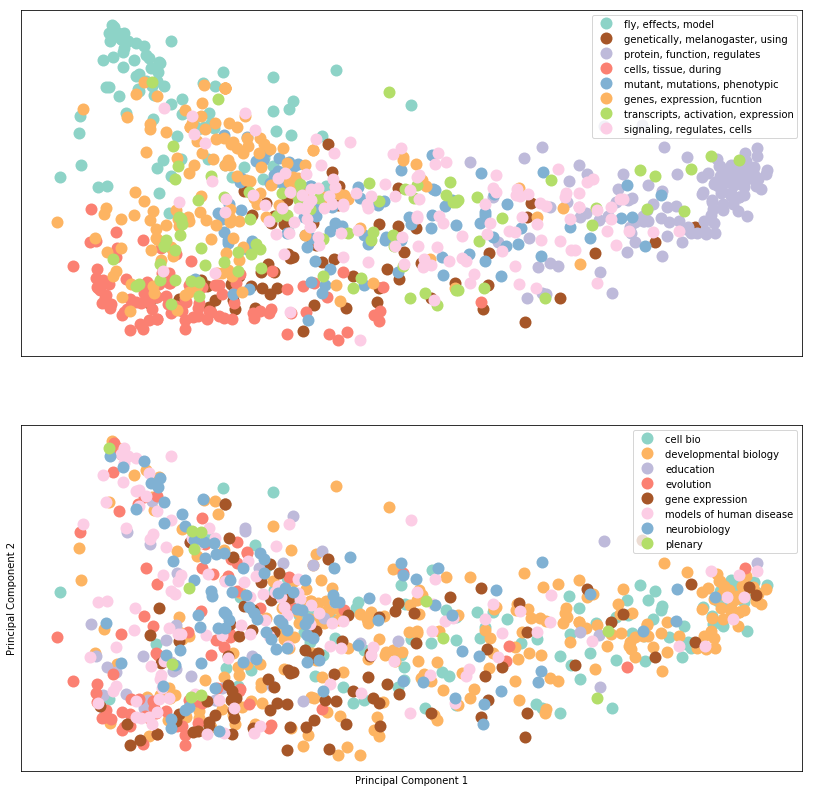

In [30]:
pca_cloud(texts, 0.8, 0.4, clusters, groups)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


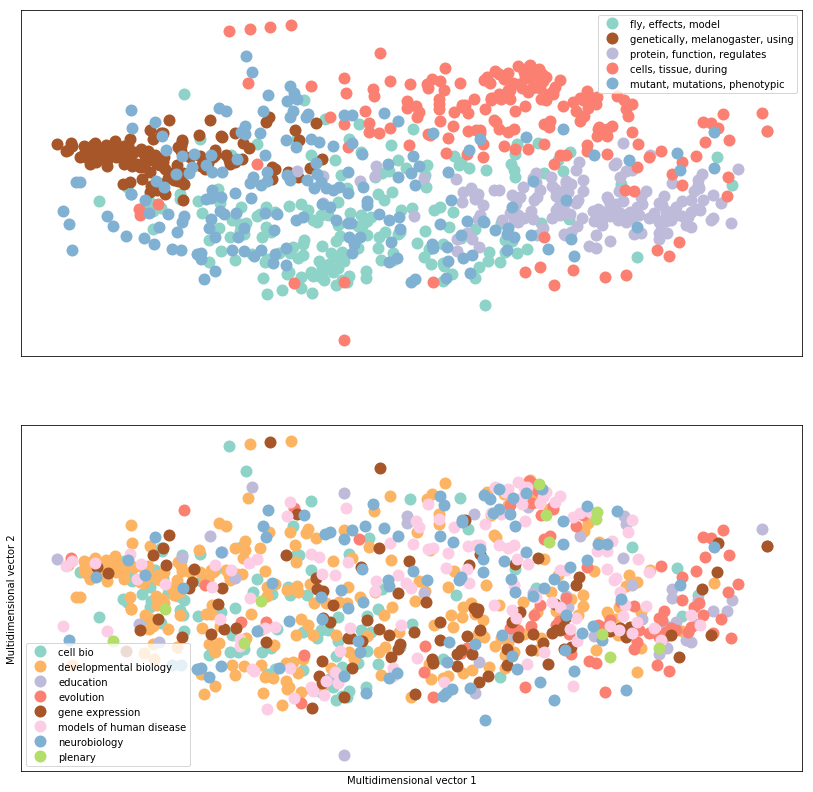

In [44]:
mds_cloud(texts, 0.8, 0.4, clusters, groups)

These plots show that the K-means clustering is doing a better job of building similar clusters than the section designations. 

## Interactive Plotting
The tutorial on that site also has a interactive graph that I want to try

"
The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with D3.js I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon mpld3 a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar."

In [26]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

"
Here is the actual creation of the interactive scatterplot. I won't go into much more detail about it since it's pretty much a straightforward copy of one of the mpld3 examples, though I use a pandas groupby to group by cluster, then iterate through the groups as I layer the scatterplot. Note that relative to doing this with raw D3, mpld3 is much simpler to integrate into your Python workflow. If you click around the rest of my website you'll see that I do love D3, but for basic interactives I will probably use mpld3 a lot going forward.

Note that mpld3 lets you define some custom CSS, which I use to style the font, the axes, and the left margin on the figure.
"

In [34]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=authors)) 

#group by cluster
groupss = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(20,12)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groupss:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)